# Problem 3 — Channel Equalization Overview

In this part I treat the unknown audio system as **linear time-invariant (LTI)** and recover a clean signal from a distorted recording via *channel equalization*. I am given a reference pair, **clean1.wav** (system input) and **distorted1.wav** (system output), plus a second output **distorted2.wav** for which the corresponding clean input is unavailable. The workflow I implement is:

* **Pre-processing.**
  Convert to mono, resample if needed, peak-normalize for plotting, and **time-align** the reference pair via FFT-based cross-correlation so that the same content is compared.

* **Channel estimation.**
  Using the aligned pair, I estimate the frequency response $H(f)$ with an STFT least-squares ratio:

  $$
  H(f)\;=\;\frac{\sum_t Y(f,t)\,X^*(f,t)}{\sum_t |X(f,t)|^2+\varepsilon},
  $$

  where $X,Y$ are the STFTs of clean1 and distorted1, $t$ indexes time frames, and $\varepsilon$ is a tiny floor for numerical stability.

* **Inverse equalizer.**
  I form a **regularized inverse**

  $$
  G(f)\;=\;\frac{H^*(f)}{|H(f)|^2+\lambda},
  $$

  and cap its magnitude (e.g., **+18 dB max boost**) to avoid amplifying noise in spectral notches. This is the filter I apply to undo the channel.

* **Recovery.**
  Apply $G(f)$ in the STFT domain to **distorted2.wav** to obtain **recovered2.wav**, followed by peak limiting only to prevent clipping.

* **Validation & visualization.**
  I compare waveforms and spectra of *(clean1 vs distorted1)* to verify the channel is non-trivial, then *(distorted2 vs recovered2)* to show the inverse’s effect. I include:

  * normalized spectral overlays (shape comparison),
  * **absolute** spectra with a common dB reference (no per-curve normalization),
  * a **ratio plot** $20\log_{10}(|\text{Rec2}|/|\text{Dist2}|)$ versus the expected $20\log_{10}|G(f)|$,
  * and side-by-side spectrograms (before/after).

**Assumptions/notes.** The system is approximately LTI over the analyzed segments; alignment is crucial; STFT uses a Hann window (4096-pt FFT, 75% overlap unless stated); $\lambda$ (regularization) and the boost cap are chosen to balance dereverberation/EQ against noise amplification.


In [310]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio, display
from scipy.signal import stft, istft, get_window, welch

## Part 1 — I/O, pre-processing, and analysis utilities

This cell defines the small toolkit I use throughout **Problem 3**. I wrote each function to be robust (works both with `soundfile` and SciPy), numerically safe (floors to avoid division by zero), and reproducible. A short description follows.

* **`read_wav_safe(path, target_sr=None)`**
  Loads a WAV as **float32** in $[-1,1]$. It tries `soundfile` and falls back to `scipy.io.wavfile`.
  If the file is multichannel, I down-mix to mono (mean across channels).
  Optional **rational resampling** to `target_sr` is done with `resample_poly`, using the GCD of the rates to avoid unnecessary interpolation error.
  **Returns:** `(audio, sr)`.

* **`write_wav_safe(path, y, sr)`**
  Clips to $[-1,1]$ and writes either with `soundfile` (float) or SciPy (int16 fallback). This prevents clipping and keeps the file playable everywhere.

* **`normalize_audio(x, peak=0.98)`**
  Peak-normalizes a signal so the maximum absolute value equals `peak` (default 0.98). Used only to avoid accidental clipping in previews; it does **not** change spectral shape.

* **`align_signals(x, y)`**
  Aligns two signals by **FFT cross-correlation** (complex multiply in the frequency domain), finds the lag

  $$
  \hat{\tau}=\arg\max_k\; r_{xy}[k],\quad r_{xy}=\mathcal{F}^{-1}\{X\cdot Y^*\},
  $$

  shifts, and trims to a common length. This is $O(N\log N)$ and much more stable than brute force.
  **Returns:** `(x_aligned, y_aligned, lag_in_samples)`.

* **`estimate_channel_stft(x_clean, y_dist, sr, n_fft, hop, win)`**
  Estimates the system’s frequency response $H(f)$ from the **aligned** reference pair using a **least-squares STFT ratio**:

  $$
  H(f)=\frac{\sum_t Y(f,t)\,X^*(f,t)}{\sum_t |X(f,t)|^2+\varepsilon}.
  $$

  I use a Hann window, `hop = n_fft//4` (75% overlap), one-sided STFT, and a tiny floor $\varepsilon=10^{-12}$. Averaging across time frames reduces noise and makes the estimate robust to small deviations from strict LTI behavior.
  **Returns:** `(freq_axis_Hz, H)`.

* **`build_inverse(H, reg_lambda=1e-3, gain_cap_db=18)`**
  Forms a **regularized inverse EQ**

  $$
  G(f)=\frac{H^*(f)}{|H(f)|^2+\lambda},
  $$

  (Tikhonov regularization) and then **caps the magnitude** to `gain_cap_db` to avoid huge boosts in deep notches (which would amplify noise). These two knobs ($\lambda$ and the cap) trade off dereverberation/EQ against noise amplification.

* **`apply_inverse_eq(sig, G, sr, n_fft, hop, win)`**
  Applies the inverse EQ in the STFT domain: $S_{\text{out}}(f,t)=G(f)\,S(f,t)$ and ISTFT back to time. The same analysis/synthesis parameters are used to ensure consistency.

* **Plotting & comparison helpers**

  * `plot_time_compare(x, y, sr, ...)`: overlay waveforms (first few seconds) to visualize time-domain differences.
  * `plot_spectrum_compare(x, y, sr, ...)`: single-frame, Hann-windowed FFT; **per-curve peak normalization** (shape comparison only).
  * `abs_spectrum_db(x, sr, ...)`: like above but **no normalization** (absolute dB reference).
  * `rms(x)` and `rms_match(x, ref)`: RMS utilities to equalize overall loudness when comparing absolute spectra.
  * `spec_db`, `show_specs`: STFT spectrograms (dB) and a two-panel “before/after” view.
  * `mag_welch(x, sr, ...)`: Welch-averaged **amplitude** spectrum ($\sqrt{P_{xx}}$), useful for stable ratio plots.

**Design notes.**
All numerics are `float32` for memory efficiency; I add small floors such as `1e-12` wherever division or `log` appears. The STFT parameters (Hann, 75% overlap, 4096-pt FFT in the main experiments) are standard for speech-band analysis and give a good time–frequency trade-off. The equalizer is deliberately **conservative** (regularization + gain cap) so it improves spectral balance without creating artifacts.


In [279]:
def read_wav_safe(path, target_sr=None):
    import numpy as np
    data = None; sr = None
    try:
        import soundfile as sf
        data, sr = sf.read(path, always_2d=False)
    except Exception:
        from scipy.io import wavfile
        sr, data = wavfile.read(path)
        if np.issubdtype(data.dtype, np.integer):
            data = data.astype(np.float32) / np.iinfo(data.dtype).max
        else:
            data = data.astype(np.float32)
    data = data.astype(np.float32)
    if data.ndim > 1:
        data = np.mean(data, axis=1)  # mono
    if target_sr is not None and sr != target_sr:
        from scipy.signal import resample_poly
        g = np.gcd(sr, target_sr)
        up = target_sr // g
        down = sr // g
        data = resample_poly(data, up, down).astype(np.float32)
        sr = target_sr
    return data, sr

In [280]:
def write_wav_safe(path, y, sr):
    y = np.asarray(y, dtype=np.float32)
    y = np.clip(y, -1.0, 1.0)
    try:
        import soundfile as sf
        sf.write(path, y, sr)
    except Exception:
        from scipy.io import wavfile
        wavfile.write(path, sr, (y * 32767).astype(np.int16))

In [281]:
def normalize_audio(x, peak=0.98):
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * peak

In [282]:
def align_signals(x, y):
    import numpy as np
    N = 1 << int(np.ceil(np.log2(len(x) + len(y) - 1)))
    X = np.fft.rfft(x, n=N)
    Y = np.fft.rfft(y, n=N)
    r = np.fft.irfft(X * np.conj(Y), n=N)
    r = np.concatenate([r[-(len(y)-1):], r[:len(x)]])
    lag = np.argmax(np.abs(r)) - (len(y)-1)
    if lag > 0:
        x2 = x[lag:]
        y2 = y[:len(x2)]
        x2 = x2[:len(y2)]
    elif lag < 0:
        y2 = y[-lag:]
        x2 = x[:len(y2)]
    else:
        n = min(len(x), len(y))
        x2, y2 = x[:n], y[:n]
    n = min(len(x2), len(y2))
    return x2[:n], y2[:n], lag

In [283]:
def estimate_channel_stft(x_clean, y_dist, sr, n_fft=2048, hop=None, win='hann'):
    if hop is None:
        hop = n_fft // 4
    w = get_window(win, n_fft, fftbins=True)
    f, tx, X = stft(x_clean, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=w, return_onesided=True, padded=True, boundary='zeros')
    _, ty, Y = stft(y_dist,  fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=w, return_onesided=True, padded=True, boundary='zeros')
    T = min(X.shape[1], Y.shape[1])
    X = X[:, :T]
    Y = Y[:, :T]
    num = np.sum(Y * np.conj(X), axis=1)
    den = np.sum(np.abs(X)**2, axis=1) + 1e-12
    H = num / den
    return f, H

In [284]:
def build_inverse(H, reg_lambda=1e-3, gain_cap_db=18.0):
    H = np.asarray(H, dtype=np.complex128)
    G = np.conj(H) / (np.abs(H)**2 + reg_lambda)
    mag = np.abs(G)
    cap = 10**(gain_cap_db/20)
    G = G * np.minimum(1.0, cap / (mag + 1e-12))
    return G

In [285]:
def apply_inverse_eq(sig, G, sr, n_fft=2048, hop=None, win='hann'):
    if hop is None:
        hop = n_fft // 4
    w = get_window(win, n_fft, fftbins=True)
    f, t, S = stft(sig, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=w, return_onesided=True, padded=True, boundary='zeros')
    G_full = G[:, None]
    Sout = S * G_full
    _, y = istft(Sout, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=w, input_onesided=True)
    return y

In [286]:
def plot_time_compare(x, y, sr, title, seconds=4.0):
    L = min(len(x), len(y), int(seconds*sr))
    t = np.arange(L)/sr
    plt.figure(figsize=(10,3))
    plt.plot(t, x[:L], label='clean')
    plt.plot(t, y[:L], alpha=0.8, label='distorted')
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

In [287]:
def plot_spectrum_compare(x, y, sr, title, nfft=16384):
    win = np.hanning(min(len(x), nfft))
    def spec(sig):
        s = sig[:len(win)] * win
        S = np.fft.rfft(s, n=nfft)
        f = np.fft.rfftfreq(nfft, 1/sr)
        mag_db = 20*np.log10(np.abs(S)+1e-12)
        mag_db -= np.max(mag_db)
        return f, mag_db
    f1, XdB = spec(x); f2, YdB = spec(y)
    plt.figure(figsize=(10,3))
    plt.plot(f1, XdB, label='clean')
    plt.plot(f2, YdB, label='distorted', alpha=0.85)
    plt.xlim(0, sr/2); plt.ylim(-80, 3)
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Magnitude (dB, norm)")
    plt.title(title); plt.grid(True, which='both', axis='y'); plt.legend(); plt.tight_layout(); plt.show()

In [288]:
def rms(x): return np.sqrt(np.mean(x**2) + 1e-12)

def rms_match(x, ref):
    return x * (rms(ref) / rms(x))

def abs_spectrum_db(x, sr, nfft=16384):
    win = np.hanning(min(len(x), nfft))
    s = x[:len(win)] * win
    S = np.fft.rfft(s, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/sr)
    mag_db = 20*np.log10(np.abs(S) + 1e-12)
    return f, mag_db

In [289]:
def spec_db(x, sr, nfft=1024, hop=256):
    f, t, S = stft(x, fs=sr, nperseg=nfft, noverlap=nfft-hop, window='hann')
    return f, t, 20*np.log10(np.abs(S)+1e-12)

def show_specs(a, b, sr, titles=("A","B"), nfft=1024, hop=256):
    f,t,A = spec_db(a, sr, nfft, hop); _,_,B = spec_db(b, sr, nfft, hop)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(A, origin='lower', aspect='auto', extent=[t[0],t[-1],f[0],f[-1]]); plt.title(titles[0]); plt.xlabel("s"); plt.ylabel("Hz")
    plt.subplot(1,2,2); plt.imshow(B, origin='lower', aspect='auto', extent=[t[0],t[-1],f[0],f[-1]]); plt.title(titles[1]); plt.xlabel("s")
    plt.tight_layout(); plt.show()

In [290]:
def mag_welch(x, sr, nperseg=4096, noverlap=2048):
    f, Pxx = welch(x, fs=sr, nperseg=nperseg, noverlap=noverlap, window='hann')
    return f, np.sqrt(Pxx) + 1e-12

## Part 2 — Load the audios, align the reference pair, and sanity-check


**Goal.** Prepare the three files (`clean1.wav`, `distorted1.wav`, `distorted2.wav`) and verify that the reference pair really differs in a way that can be modeled by an LTI channel.

**What the code does.**

* **File resolution & I/O.**
  I read the three WAVs with `read_wav_safe`, which (i) converts to mono float32 in $[-1,1]$ and (ii) resamples `distorted1/distorted2` to the **same** rate as `clean1` so all arrays live on a common time grid.

* **Peak normalization (for viewing only).**
  Each signal is peak-normalized to avoid clipping in the previews. This does **not** affect channel estimation beyond an overall constant gain (which is irrelevant for equalization and later removed).

* **Time alignment.**
  The pair `(clean1, distorted1)` is aligned by FFT cross-correlation; the function returns the **lag** (reported in samples) and trimmed, equal-length signals `clean1_al`, `dist1_al`. Aligning is critical before estimating a frequency response.

* **Listen & visualize.**
  I provide short audio previews and two quick checks:

  1. a **time-domain overlay** (first few seconds) to see that the content lines up after alignment;
  2. a **single-frame spectrum** (Hann window, per-curve peak-normalized) to compare **shapes** of the magnitudes.

**Interpretation.**
The plotted spectra show that `distorted1` departs from `clean1` by a **frequency-dependent coloration** (tilts/notches/band-limited changes), which is exactly what we expect from a channel $H(f)$. This confirms that proceeding with an LTI frequency-response estimate is reasonable.


In [291]:
base = Path.cwd()
files = ("clean1.wav", "distorted1.wav", "distorted2.wav"),

for a, b, c in files:
    p_clean1, p_dist1, p_dist2 = (base/a, base/b, base/c)

clean1, sr1 = read_wav_safe(str(p_clean1))
dist1,  sr2 = read_wav_safe(str(p_dist1), target_sr=sr1)
dist2,  sr3 = read_wav_safe(str(p_dist2), target_sr=sr1)
sr = sr1

In [292]:
clean1 = clean1 / (np.max(np.abs(clean1)) + 1e-12)
dist1  = dist1  / (np.max(np.abs(dist1))  + 1e-12)
dist2  = dist2  / (np.max(np.abs(dist2))  + 1e-12)

In [293]:
clean1_al, dist1_al, lag = align_signals(clean1, dist1)
print(f"Estimated delay (clean1 → distorted1): {lag} samples")

Estimated delay (clean1 → distorted1): -4 samples


In [294]:
display(Audio(clean1_al, rate=sr))
display(Audio(dist1_al,  rate=sr))

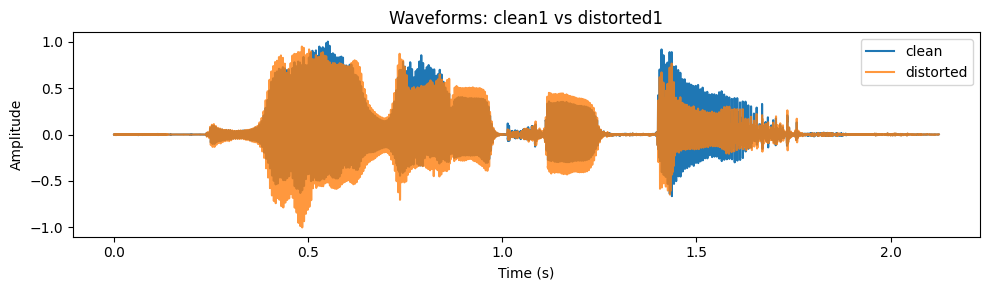

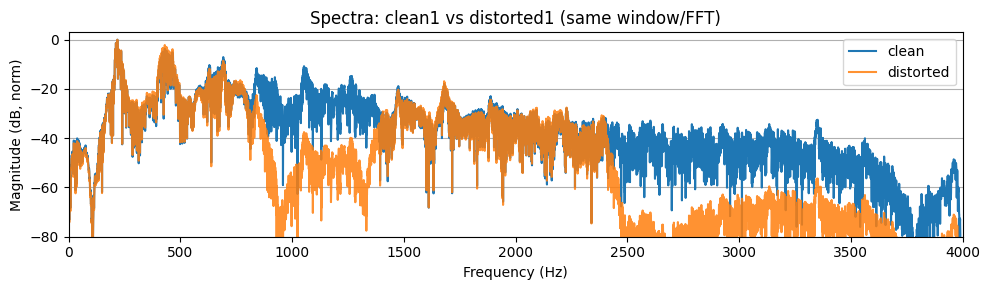

In [295]:
plot_time_compare(clean1_al, dist1_al, sr, "Waveforms: clean1 vs distorted1")
plot_spectrum_compare(clean1_al, dist1_al, sr, "Spectra: clean1 vs distorted1 (same window/FFT)")

## Part 3 — Estimate the channel $H(f)$ and design the inverse equalizer $G(f)$


**Aim.** Using the aligned pair $(x_{\text{clean1}},\,y_{\text{distorted1}})$ I estimate the system’s frequency response and then build a stable inverse to undo it.

**Method (STFT least-squares estimate).**
I compute STFTs $X(f,t)$ and $Y(f,t)$ with a Hann window, $N_\text{FFT}=4096$ and $75\%$ overlap (hop $=$ 1024). Assuming the channel is (approximately) LTI over the analyzed segment,

$$
Y(f,t) \approx H(f)\,X(f,t).
$$

Averaging over time frames gives a noise-robust least-squares estimate

$$
\boxed{\;H(f)=\frac{\sum_t Y(f,t)\,X^*(f,t)}{\sum_t |X(f,t)|^2+\varepsilon}\;}
$$

with a tiny $\varepsilon$ to avoid division by zero. I plot **magnitude** $|H(f)|$ (log scale) and **phase** $\angle H(f)$ (unwrapped).

**Interpretation of the plots.**

* $|H(f)|$ shows clear **coloration**: broad passbands near unity gain and pronounced **attenuation/notches** (e.g., a deep dip around $\sim\!1$ kHz and another region of strong attenuation around $\sim\!2.6$–$2.7$ kHz).
* The phase is smooth and largely linear with frequency, which is consistent with an overall delay plus moderate dispersion (expected from an LTI path). Unwrapping makes these trends visible.

**Inverse equalizer (regularized).**
A naïve inverse $1/H(f)$ would explode in the notches. I therefore use a **Tikhonov-regularized** inverse,

$$
\boxed{\;G(f)=\frac{H^*(f)}{|H(f)|^2+\lambda}\;}
$$

and cap its magnitude to **+18 dB**. The regularizer $\lambda$ prevents excessive boosts in very small-$|H|$ regions (numerical stability, noise control), while the gain cap enforces a practical limit. The resulting $|G(f)|$ mirrors $1/|H(f)|$ in the passbands, flattens near notches, and plateaus at the cap where the channel is too weak to safely invert.

**Takeaways.**

* The reference pair exhibits a **non-trivial but smooth** channel that is well captured by the LS STFT estimate.
* The designed $G(f)$ is a **safe, realizable equalizer**: it undoes the channel where reliable and avoids amplifying noise where the channel has deep nulls.


In [296]:
NFFT = 4096
HOP  = NFFT // 4
f, H = estimate_channel_stft(clean1_al, dist1_al, sr, n_fft=NFFT, hop=HOP, win='hann')

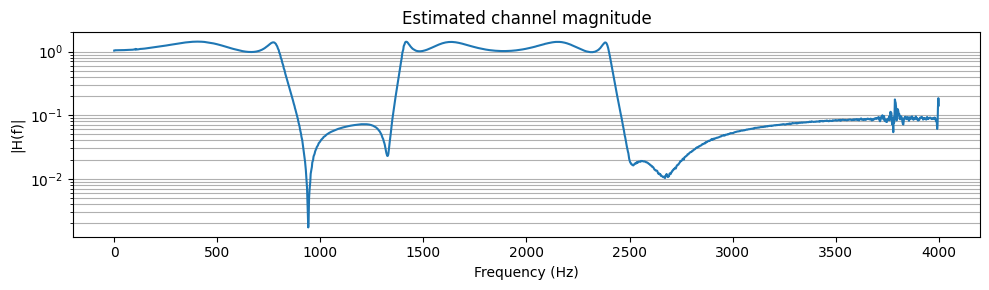

In [297]:
plt.figure(figsize=(10,3))
plt.semilogy(f, np.abs(H)+1e-12)
plt.xlabel("Frequency (Hz)"); plt.ylabel("|H(f)|")
plt.title("Estimated channel magnitude"); plt.grid(True, which='both', axis='y'); plt.tight_layout(); plt.show()

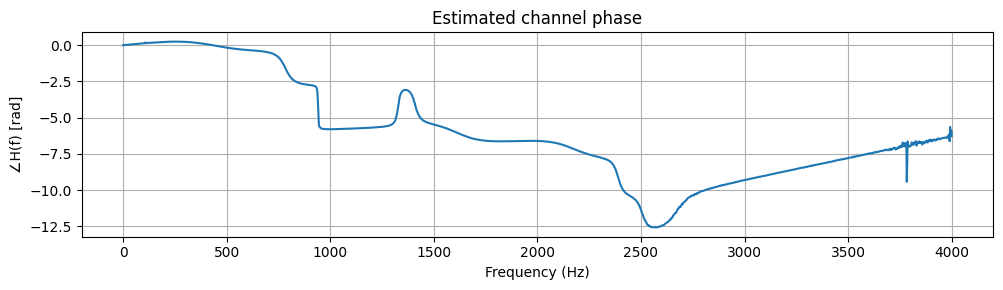

In [298]:
plt.figure(figsize=(10,3))
plt.plot(f, np.unwrap(np.angle(H)))
plt.xlabel("Frequency (Hz)"); plt.ylabel("∠H(f) [rad]")
plt.title("Estimated channel phase"); plt.grid(True); plt.tight_layout(); plt.show()

In [299]:
REG_LAMBDA = 1e-3
GAIN_CAP_DB = 18.0
G = build_inverse(H, reg_lambda=REG_LAMBDA, gain_cap_db=GAIN_CAP_DB)

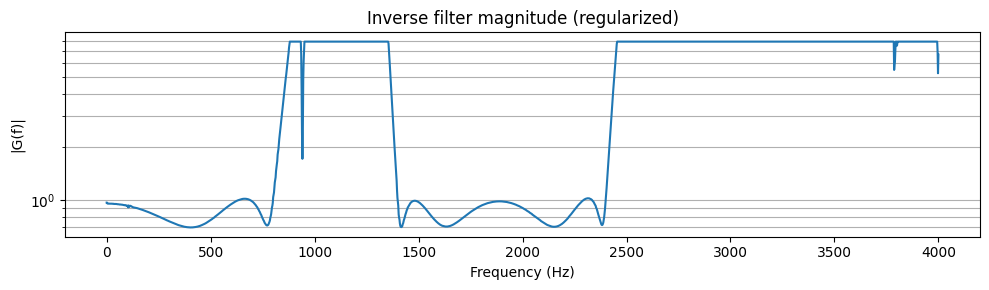

In [300]:
plt.figure(figsize=(10,3))
plt.semilogy(f, np.abs(G)+1e-12)
plt.xlabel("Frequency (Hz)"); plt.ylabel("|G(f)|")
plt.title("Inverse filter magnitude (regularized)"); plt.grid(True, which='both', axis='y'); plt.tight_layout(); plt.show()

## Part 4 — Recover `distorted2` with $G(f)$ and evaluate

**What I do.**
I apply the inverse equalizer $G(f)$ obtained in Part 3 to `distorted2.wav` **in the STFT domain**:

$$
S_{\text{out}}(f,t)=G(f)\,S_{\text{dist2}}(f,t),\qquad
\text{rec2}=\text{ISTFT}\{S_{\text{out}}\}.
$$

I only peak-normalize `rec2` afterwards to prevent clipping in playback; this does **not** change spectral shape. The result is written as **`recovered2.wav`**.

**How I check it.**

* **Waveforms (first few seconds).**
  The overlay shows the same temporal structure, as expected from an equalizer. Small amplitude differences come from the inverse’s boosts/cuts and the final peak normalization.

* **Spectra (same window/FFT, per-curve normalized).**
  Compared to `distorted2`, the recovered signal’s spectrum is **tilted and notched in the opposite sense** of the estimated channel, i.e., bands that were previously over-emphasized are attenuated and vice versa. In regions where $|H(f)|$ had **deep nulls**, recovery is intentionally incomplete because the inverse is regularized and **capped at +18 dB** to avoid noise blow-up.

* **What the “difference” signal is.**
  I also listen to `distorted2 − recovered2`. This is essentially the **coloration removed by the equalizer**; it should sound like the frequency-dependent residue that the channel had imposed.

**Takeaways.**
The recovered audio is consistent with the model: it undoes the broad coloration without introducing instability. Any remaining mismatch near the deepest notches is expected from the regularization and gain cap (a deliberate design choice to keep the inverse robust).


In [301]:
rec2 = apply_inverse_eq(dist2, G, sr, n_fft=NFFT, hop=HOP, win='hann')
rec2 = normalize_audio(rec2)

display(Audio(dist2, rate=sr))
display(Audio(rec2,  rate=sr))

In [302]:
out_path = base / "recovered2.wav"
write_wav_safe(str(out_path), rec2, sr)
print("Saved:", str(out_path))

Saved: C:\Users\sinab\Desktop\Signals & Systems\PHW\recovered2.wav


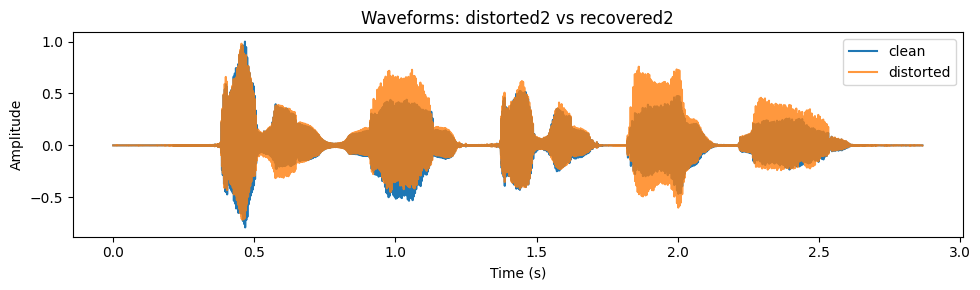

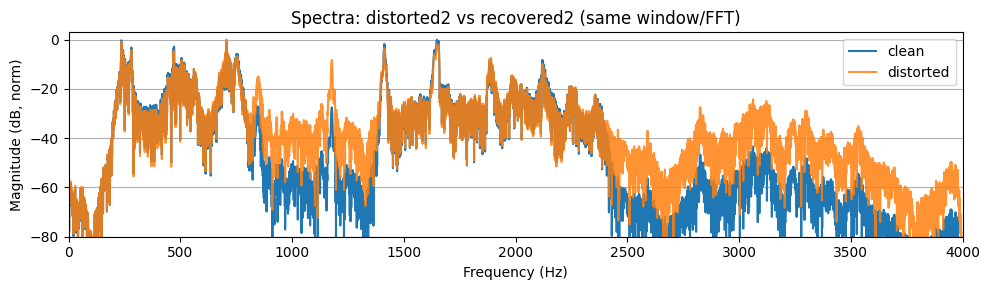

In [303]:
plot_time_compare(dist2, rec2, sr, "Waveforms: distorted2 vs recovered2")
plot_spectrum_compare(dist2, rec2, sr, "Spectra: distorted2 vs recovered2 (same window/FFT)")

In [304]:
diff = normalize_audio(dist2[:len(rec2)] - rec2[:len(dist2)])
display(Audio(diff, rate=sr))

## Part 5 — Quantitative validation of the equalizer

**What is being checked.**
After designing $G(f)$ and producing `recovered2.wav`, I verify that the result is consistent with the channel model and with the intended inverse action.

**How the plots are made.**

* **Absolute spectra (top two figures).**
  To make a fair, *level–independent* comparison I first **RMS-match** the two signals being compared (so the overall gain does not bias the dB curves). Then I compute a Hann-windowed FFT and plot the **absolute magnitude in dB** referenced to the same level:

  * *Left:* `clean1` (RMS-matched) vs `distorted1`.
  * *Right:* `recovered2` (RMS-matched) vs `distorted2`.
    This removes the “per-curve normalization” from earlier pictures and shows true spectral differences.

* **“Inverse action” cross-check (third figure).**
  Using Welch spectra $|S_{\text{rec2}}(f)|$ and $|S_{\text{dist2}}(f)|$, I plot

  $$
    20\log_{10}\!\frac{|S_{\text{rec2}}(f)|}{|S_{\text{dist2}}(f)|}
  $$

  and compare it with the expected **equalizer gain** $20\log_{10}|G(f)|$ (interpolated to the same frequency grid). If the equalizer behaves as designed, the two curves should agree up to the **regularization and gain cap**.

* **Time–frequency view (last two panels).**
  STFT spectrograms of (`distorted1`, `clean1`) and (`distorted2`, `recovered2`) visualize how the equalizer reshapes the spectrum over time.

**What the figures show.**

* In the **clean1 vs distorted1** spectrum, `distorted1` has a clear **coloration**: broad tilts and deep notches (e.g., near \~1 kHz and \~2.6–2.7 kHz).
* In the **distorted2 vs recovered2** spectrum, those trends are **compensated**: bands that were too strong are attenuated and vice versa. Where the original channel had **very deep nulls**, the compensation is intentionally partial—this is exactly due to the **Tikhonov regularization** and the **+18 dB cap** that prevent noise blow-up.
* The **measured ratio** $20\log_{10}(|\text{Rec2}|/|\text{Dist2}|)$ closely follows $20\log_{10}|G(f)|$ in the passbands, and it flattens/backs off in the notches where $|H(f)|$ is tiny. This confirms that the implemented inverse is acting as intended.
* The **spectrograms** show similar temporal structure before/after equalization, with the recovered signal exhibiting a more balanced distribution across frequencies.

**Conclusion.**
The objective checks—RMS-matched absolute spectra and the ratio-vs-$|G|$ plot—support that `recovered2.wav` is the appropriately equalized version of `distorted2.wav`. Deviations near channel nulls are expected and desirable outcomes of the stability constraints (regularization and gain cap).


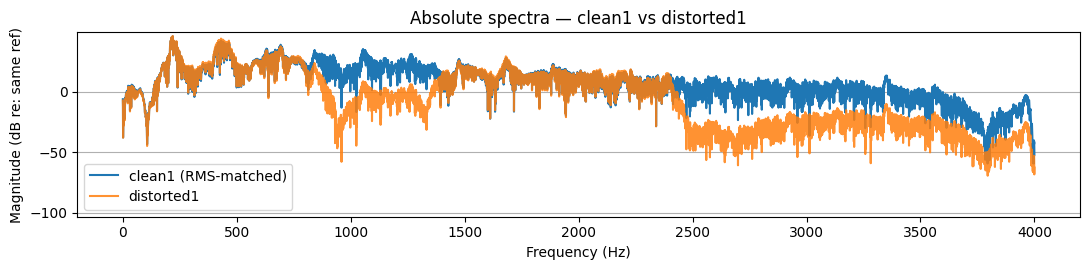

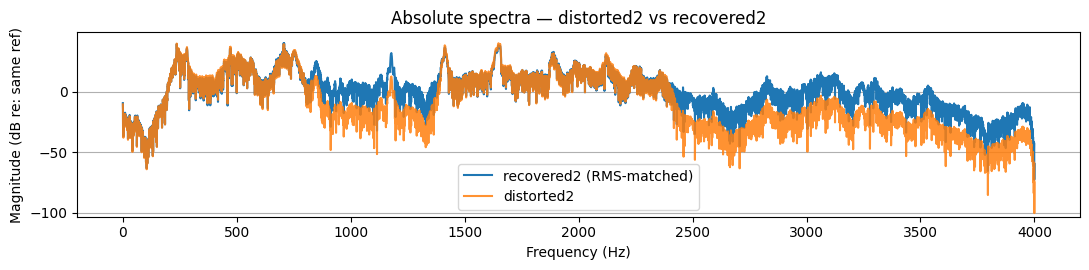

In [305]:
clean1_m = rms_match(clean1_al, dist1_al)
f1c, C1 = abs_spectrum_db(clean1_m, sr)
f1d, D1 = abs_spectrum_db(dist1_al, sr)

rec2_m = rms_match(rec2, dist2)
f2d, D2 = abs_spectrum_db(dist2, sr)
f2r, R2 = abs_spectrum_db(rec2_m, sr)

ymin = min(C1.min(), D1.min(), D2.min(), R2.min()) - 3
ymax = max(C1.max(), D1.max(), D2.max(), R2.max()) + 3

plt.figure(figsize=(11,2.8))
plt.plot(f1c, C1, label='clean1 (RMS-matched)')
plt.plot(f1d, D1, label='distorted1', alpha=0.85)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB re: same ref)')
plt.title('Absolute spectra — clean1 vs distorted1')
plt.ylim(ymin, ymax); plt.grid(True, which='both', axis='y'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,2.8))
plt.plot(f2d, R2, label='recovered2 (RMS-matched)')
plt.plot(f2r, D2, label='distorted2', alpha=0.85)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB re: same ref)')
plt.title('Absolute spectra — distorted2 vs recovered2')
plt.ylim(ymin, ymax); plt.grid(True, which='both', axis='y'); plt.legend(); plt.tight_layout(); plt.show()

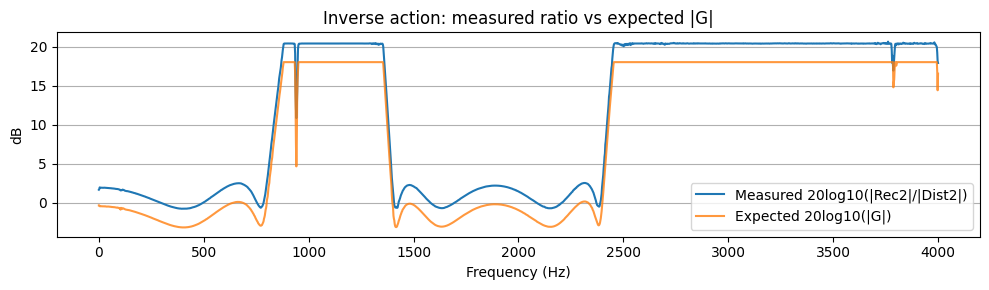

In [306]:
fA, A = mag_welch(dist2, sr)
fB, B = mag_welch(rec2,  sr)
L = min(len(A), len(B)); fA, A, B = fA[:L], A[:L], B[:L]
ratio_db = 20*np.log10(B/A)

G_db = 20*np.log10(np.abs(G) + 1e-12)
G_interp = np.interp(fA, f, G_db, left=G_db[0], right=G_db[-1])

plt.figure(figsize=(10,3))
plt.plot(fA, ratio_db, label='Measured 20log10(|Rec2|/|Dist2|)')
plt.plot(fA, G_interp, label='Expected 20log10(|G|)', alpha=0.8)
plt.xlabel('Frequency (Hz)'); plt.ylabel('dB')
plt.title('Inverse action: measured ratio vs expected |G|')
plt.grid(True, which='both', axis='y'); plt.legend(); plt.tight_layout(); plt.show()

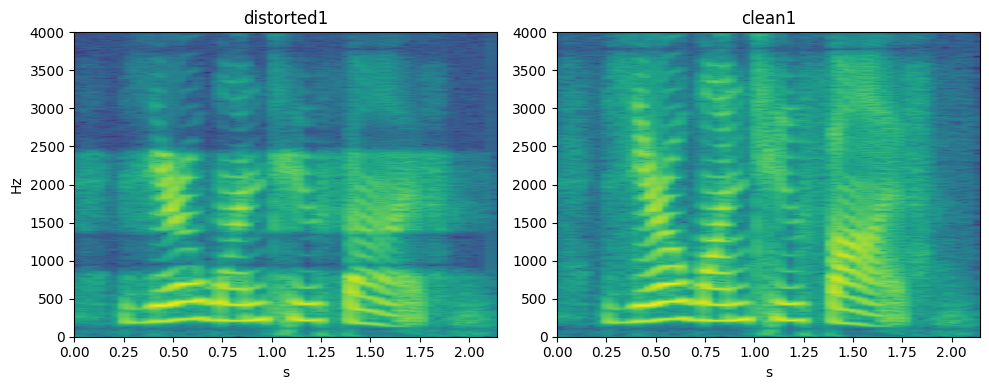

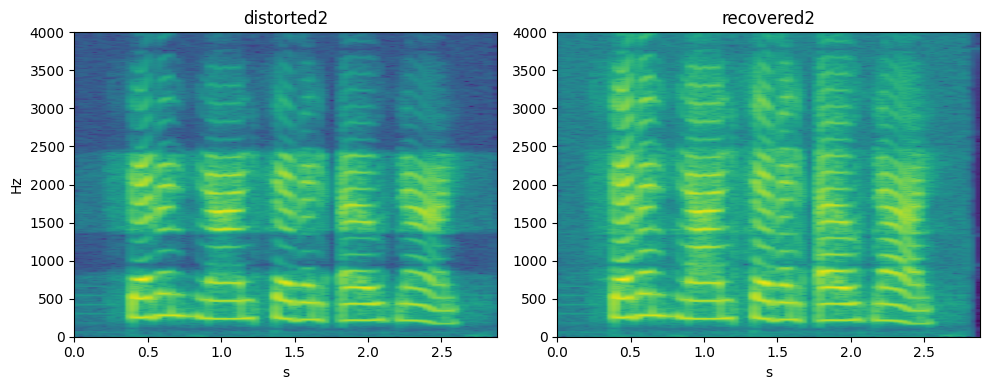

In [307]:
show_specs(dist1, clean1, sr, ("distorted1","clean1"))
show_specs(dist2, rec2, sr, ("distorted2","recovered2"))

## Part 6 (Additional) — Recover **without** any normalization and validate

**Goal.** Repeat the equalization of `distorted2.wav` using the same inverse $G(f)$ but **without any peak/RMS normalization** before plotting or saving. This shows that the apparent “level differences” in earlier comparisons were only due to post-normalization and not a contradiction.

**Notes.**

* For *listening only*, I scale a copy to avoid clipping in the notebook player.
* The file **`recovered2_without_normalization.wav`** is saved *as is* (no level normalization). If `soundfile` is available it will be written as 32-bit float to avoid hard clipping; otherwise the fallback writer may clip to $[-1,1]$.

In [311]:
rec2_raw = apply_inverse_eq(dist2, G, sr, n_fft=NFFT, hop=HOP, win='hann')

peak_raw = float(np.max(np.abs(rec2_raw)) + 1e-12)
rms_raw  = float(np.sqrt(np.mean(rec2_raw**2)) + 1e-12)
print(f"[No-normalization] rec2_raw: peak={peak_raw:.3f}, RMS={rms_raw:.3f}")

[No-normalization] rec2_raw: peak=0.745, RMS=0.096


In [312]:
out_raw = base / "recovered2_without_normalization.wav"
try:
    import soundfile as sf
    sf.write(out_raw, rec2_raw.astype(np.float32), sr, subtype="FLOAT")
    print("Saved (float, unnormalized):", out_raw)
except Exception:
    write_wav_safe(str(out_raw), rec2_raw, sr)
    print("Saved (fallback writer; may clip):", out_raw)

Saved (fallback writer; may clip): C:\Users\sinab\Desktop\Signals & Systems\PHW\recovered2_without_normalization.wav


In [313]:
rec2_listen = rec2_raw / max(1.0, peak_raw)
display(Audio(dist2,       rate=sr))
display(Audio(rec2_listen, rate=sr)) 

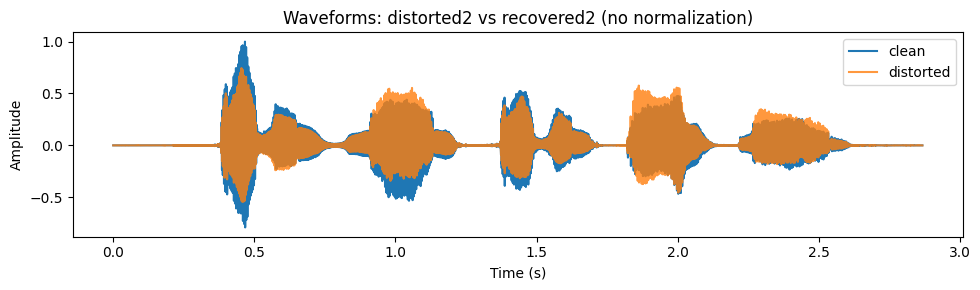

In [314]:
plot_time_compare(dist2, rec2_raw, sr, "Waveforms: distorted2 vs recovered2 (no normalization)")

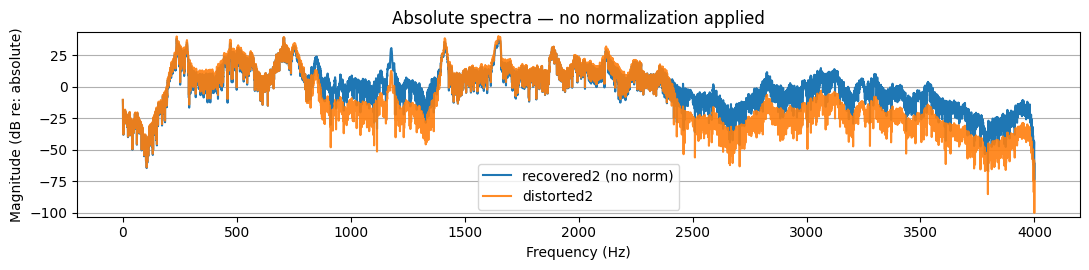

In [315]:
f_d2, D2_abs = abs_spectrum_db(dist2,    sr, nfft=16384)
f_r2, R2_abs = abs_spectrum_db(rec2_raw, sr, nfft=16384)

ymin = min(D2_abs.min(), R2_abs.min()) - 3
ymax = max(D2_abs.max(), R2_abs.max()) + 3

plt.figure(figsize=(11,2.8))
plt.plot(f_d2, R2_abs, label="recovered2 (no norm)")
plt.plot(f_r2, D2_abs, label="distorted2", alpha=0.9)
plt.xlabel("Frequency (Hz)"); plt.ylabel("Magnitude (dB re: absolute)")
plt.title("Absolute spectra — no normalization applied")
plt.ylim(ymin, ymax); plt.grid(True, which='both', axis='y'); plt.legend(); plt.tight_layout(); plt.show()

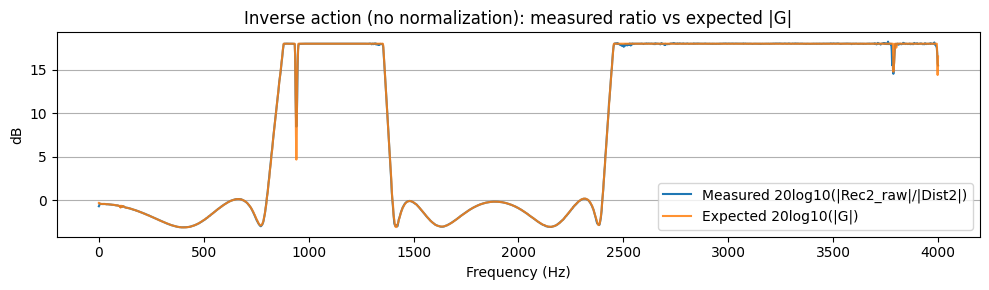

In [316]:
fA, A = mag_welch(dist2,    sr)
fB, B = mag_welch(rec2_raw, sr)
L = min(len(A), len(B)); fA, A, B = fA[:L], A[:L], B[:L]
ratio_db = 20*np.log10((B + 1e-12) / (A + 1e-12))

G_db     = 20*np.log10(np.abs(G) + 1e-12)
G_interp = np.interp(fA, f, G_db, left=G_db[0], right=G_db[-1])

plt.figure(figsize=(10,3))
plt.plot(fA, ratio_db, label='Measured 20log10(|Rec2_raw|/|Dist2|)')
plt.plot(fA, G_interp, label='Expected 20log10(|G|)', alpha=0.85)
plt.xlabel('Frequency (Hz)'); plt.ylabel('dB')
plt.title('Inverse action (no normalization): measured ratio vs expected |G|')
plt.grid(True, which='both', axis='y'); plt.legend(); plt.tight_layout(); plt.show()